In [10]:
from dataset import load_dataset
from clean import show_nans, fill_nans
from clean import show_boxplot, remove_outliers
from knn import knn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold

# Dataset

In [2]:
df = load_dataset()
df.head(5)

Dataset files are missing.
Downloading...


8.83MiB [00:09, 885kiB/s] 


Unzipping...
Cleaning...


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


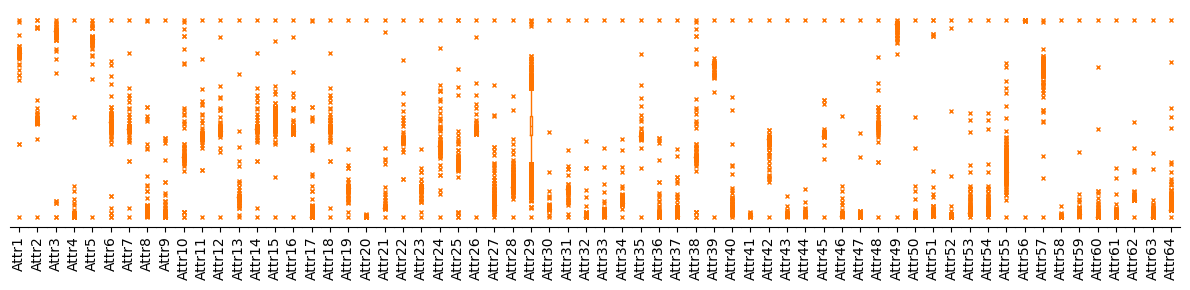

In [3]:
show_boxplot(df, iqr_ratio=1.5)

In [4]:
old_df_size = len(df) * (len(df.columns) - 1)
df = remove_outliers(df, iqr_ratio=5)
print(f"Removed {df.isna().sum().sum() / old_df_size:.2%} of the data")

Removed 4.65% of the data


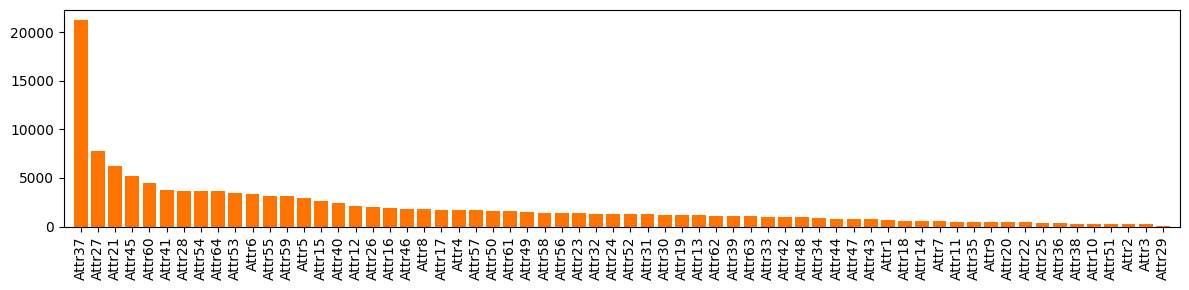

In [5]:
show_nans(df)

In [6]:
df = fill_nans(df, pd.DataFrame.median)

# KNN

In [7]:
knn(df)

,accuracy,f1,precision,recall
0,0.948554,0.493546,0.517458,0.501902


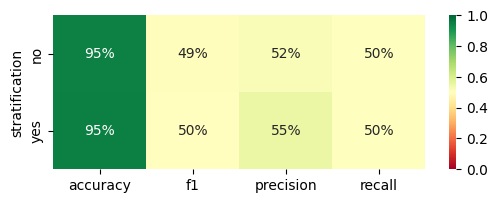

In [13]:
label = 'stratification'
combined = pd.DataFrame()
for i in [KFold, StratifiedKFold]:
    res = knn(df, i)
    res[label] = 'yes' if i == StratifiedKFold else 'no'
    combined = pd.concat([combined, res])
combined.index = combined[label]
combined.drop(columns=[label], inplace=True)
plt.figure(figsize=(6, 2))
sns.heatmap(combined, cmap="RdYlGn", vmin=0, vmax=1, annot=True, fmt=".0%")
plt.show()

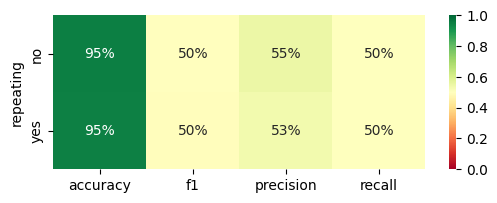

In [14]:
label = 'repeating'
combined = pd.DataFrame()
for i in [StratifiedKFold, RepeatedStratifiedKFold]:
    res = knn(df, i)
    res[label] = 'yes' if i == RepeatedStratifiedKFold else 'no'
    combined = pd.concat([combined, res])
combined.index = combined[label]
combined.drop(columns=[label], inplace=True)
plt.figure(figsize=(6, 2))
sns.heatmap(combined, cmap="RdYlGn", vmin=0, vmax=1, annot=True, fmt=".0%")
plt.show()

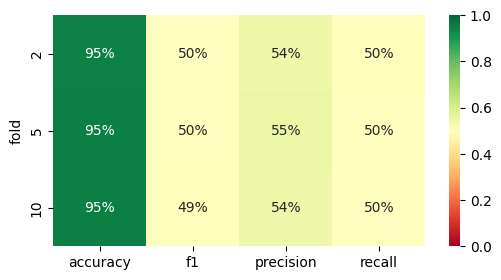

In [15]:
label = 'fold'
combined = pd.DataFrame()
for i in [2, 5, 10]:
    res = knn(df, StratifiedKFold, kf_kwargs=dict(n_splits=i))
    res[label] = i
    combined = pd.concat([combined, res])
combined.index = combined[label]
combined.drop(columns=[label], inplace=True)
plt.figure(figsize=(6, 3))
sns.heatmap(combined, cmap="RdYlGn", vmin=0, vmax=1, annot=True, fmt=".0%")
plt.show()

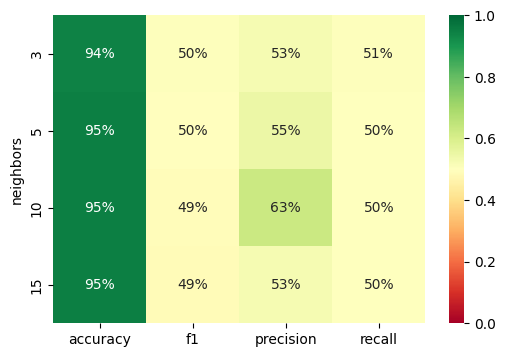

In [17]:
label = 'neighbors'
combined = pd.DataFrame()
for i in [3, 5, 10, 15]:
    res = knn(df, StratifiedKFold, kf_kwargs=dict(n_splits=5), knn_kwargs=dict(n_neighbors=i))
    res[label] = i
    combined = pd.concat([combined, res])
combined.index = combined[label]
combined.drop(columns=[label], inplace=True)
plt.figure(figsize=(6, 4))
sns.heatmap(combined, cmap="RdYlGn", vmin=0, vmax=1, annot=True, fmt=".0%")
plt.show()

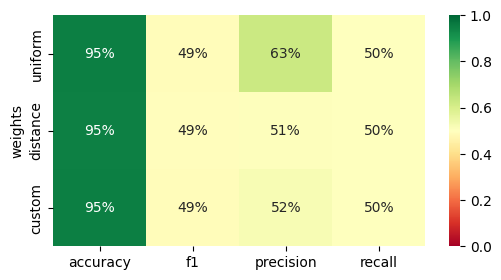

In [20]:
label = 'weights'
combined = pd.DataFrame()
custom = lambda distances: 1 / (np.log10(distances + 1.1))
for i in ['uniform', 'distance', custom]:
    res = knn(df, StratifiedKFold, kf_kwargs=dict(n_splits=5), knn_kwargs=dict(n_neighbors=10, weights=i))
    res[label] = i if isinstance(i, str) else 'custom'
    combined = pd.concat([combined, res])
combined.index = combined[label]
combined.drop(columns=[label], inplace=True)
plt.figure(figsize=(6, 3))
sns.heatmap(combined, cmap="RdYlGn", vmin=0, vmax=1, annot=True, fmt=".0%")
plt.show()

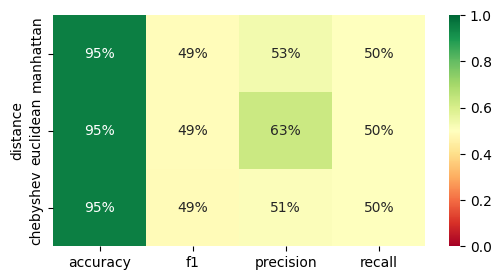

In [22]:
label = 'distance'
combined = pd.DataFrame()
for i in [1, 2, 3]:
    res = knn(df, StratifiedKFold, kf_kwargs=dict(n_splits=5), knn_kwargs=dict(n_neighbors=10, weights='uniform', p=i))
    res[label] = ['manhattan', 'euclidean', 'chebyshev'][i-1]
    combined = pd.concat([combined, res])
combined.index = combined[label]
combined.drop(columns=[label], inplace=True)
plt.figure(figsize=(6, 3))
sns.heatmap(combined, cmap="RdYlGn", vmin=0, vmax=1, annot=True, fmt=".0%")
plt.show()

In [23]:
from tqdm.notebook import tqdm
import itertools

custom = lambda distances: 1 / (np.log10(distances + 1.1))
combined = pd.DataFrame()
for fold, neighbors, weights, distance in tqdm(itertools.product(
    [2, 5, 10],
    [3, 5, 10, 15],
    ['uniform', 'distance'],
    [1, 2],
), total=3*4*2*2):
    res = knn(df, StratifiedKFold, kf_kwargs=dict(n_splits=fold), knn_kwargs=dict(n_neighbors=neighbors, weights=weights, p=distance))
    res['fold'] = fold
    res['neighbors'] = neighbors
    res['weights'] = weights
    res['distance'] = ['manhattan', 'euclidean'][distance-1]
    combined = pd.concat([combined, res])    

  0%|          | 0/48 [00:00<?, ?it/s]

In [25]:
combined.sort_values(by=['f1', 'accuracy'], ascending=False)

,accuracy,f1,precision,recall,fold,neighbors,weights,distance
0,0.936781,0.508483,0.521916,0.508440,5,3,distance,manhattan
0,0.935215,0.507530,0.518633,0.507623,10,3,distance,manhattan
0,0.942196,0.506320,0.528491,0.507653,5,3,uniform,manhattan
0,0.941988,0.505814,0.527707,0.507321,10,3,uniform,manhattan
0,0.942495,0.505560,0.528518,0.507131,2,3,uniform,euclidean
0,0.936874,0.505235,0.516560,0.506220,5,3,distance,euclidean
0,0.935814,0.504635,0.514327,0.505666,10,3,distance,euclidean
0,0.942495,0.504283,0.525131,0.506451,5,3,uniform,euclidean
0,0.939523,0.504160,0.518361,0.505797,2,3,distance,euclidean
0,0.942564,0.503951,0.524506,0.506261,10,3,uniform,euclidean
